# Preprocessing: Airline Delay
<img src="../assets/airline-pic.jpg" alt="Title-Pic">

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pandas import Series, DataFrame
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler


np.set_printoptions(suppress=True)
sns.set(rc={"figure.figsize": (10, 6), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})
warnings.filterwarnings('ignore')

# Data

In [3]:
df_raw_data = pd.read_csv("../data/Airlines.csv")
df = df_raw_data.copy()
df

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0
...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0
539379,539380,FL,398,SEA,ATL,5,1439,305,0
539380,539381,FL,609,SFO,MKE,5,1439,255,0
539381,539382,UA,78,HNL,SFO,5,1439,313,1


In [ ]:
df["Target"] = df["Delay"]
df["Delay"] = df["Delay"].map({0: "False", 1: "True"}).astype("category")

# Helper Functions & Constants

In [4]:
# columns
ID = "id"
AIRLINE = "Airline"
FLIGHT = "Flight"
AIRPORT_FROM = "AirportFrom"
AIRPORT_TO = "AirportTo"
DAY_OF_WEEK = "DayOfWeek"
TIME = "Time"
LENGTH = "Length"
TARGET_DELAY = "Delay"

# added columns
TARGET = "Target"

In [ ]:
def plot_target_relation(column_name):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    ax1, ax2 = axes
    
    target_pvt = df.pivot_table(index=column_name, values=TARGET, aggfunc="mean").sort_index()

    sns.pointplot(x=TARGET_DELAY, y=column_name, data=df, ax=ax1).set_title(f"Relation Delay and {column_name}")
    sns.regplot(x=target_pvt.index, y=target_pvt.to_numpy(), ci=False, line_kws={"color": "C1"}, scatter_kws={"alpha": 0.5}, ax=ax2).set_title(f"Linear Relation Credit-Score and {column_name}")

def plot_target_relation_cat(column_name):
    g = sns.pointplot(x=column_name, y=TARGET, data=df)
    g.set_title(f"Relation Credit-Score-Mean and {column_name}")
    g.tick_params(axis='x', rotation=45)

def plot_dist(column_name):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    ax1, ax2 = axes
    
    title = f"Distribution of {column_name}"
    ax1.set_title(title)
    ax2.set_title(title)

    sns.boxplot(x=column_name, data=df, ax=ax1)
    df[column_name].hist(ax=ax2)

    print(f"Skew: \t {df[column_name].skew()}")

def plot_dist_cat(column_name):
    g = sns.countplot(x=column_name, data=df, color="C0")
    g.tick_params(axis='x', rotation=45)
    g.set_title(f"Distribution of {column_name}")

# Data Preprocessing

## First Overview

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


In [6]:
df.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.000000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.604461,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.500000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.000000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.500000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.000000,7814.000000,7.000000,1439.000000,655.000000,1.000000


In [7]:
df.describe(include=["O"])

,Airline,AirportFrom,AirportTo
count,539383,539383,539383
unique,18,293,293
top,WN,ATL,ATL
freq,94097,34449,34440


## Drop Features

In [8]:
df.drop(columns=[ID, FLIGHT], inplace=True)

## Missing Values

In [9]:
df.isna().sum()

Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

## Numeric Features

In [10]:
df.describe()

,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000
mean,3.929668,802.728963,132.202007,0.445442
std,1.914664,278.045911,70.117016,0.497015
min,1.000000,10.000000,0.000000,0.000000
25%,2.000000,565.000000,81.000000,0.000000
50%,4.000000,795.000000,115.000000,0.000000
75%,5.000000,1035.000000,162.000000,1.000000
max,7.000000,1439.000000,655.000000,1.000000


Length    0.174745
dtype: float64

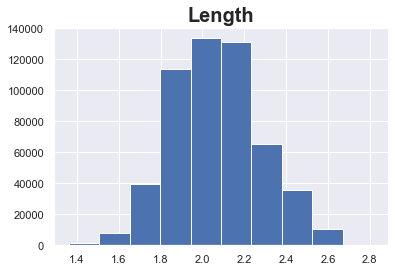

In [11]:
log_trans_features = [LENGTH]
df.loc[df[LENGTH] <= 0, LENGTH] = df[LENGTH].mean()


df[log_trans_features] = np.log10(df[log_trans_features])

df[log_trans_features].hist()
df[log_trans_features].skew()

In [12]:
scale_features = [LENGTH, TIME]
df[scale_features].describe()

,Length,Time
count,539383.000000,539383.000000
mean,2.067970,802.728963
std,0.212745,278.045911
min,1.361728,10.000000
25%,1.908485,565.000000
50%,2.060698,795.000000
75%,2.209515,1035.000000
max,2.816241,1439.000000


In [13]:
df[scale_features] = StandardScaler().fit_transform(df[scale_features])
df[scale_features].describe()

,Length,Time
count,5.393830e+05,5.393830e+05
mean,3.072318e-15,-6.238851e-17
std,1.000001e+00,1.000001e+00
min,-3.319672e+00,-2.851075e+00
25%,-7.496549e-01,-8.549997e-01
50%,-3.418275e-02,-2.779746e-02
75%,6.653282e-01,8.353701e-01
max,3.517228e+00,2.288369e+00


In [14]:
df.describe()

,DayOfWeek,Time,Length,Delay
count,539383.000000,5.393830e+05,5.393830e+05,539383.000000
mean,3.929668,-6.238851e-17,3.072318e-15,0.445442
std,1.914664,1.000001e+00,1.000001e+00,0.497015
min,1.000000,-2.851075e+00,-3.319672e+00,0.000000
25%,2.000000,-8.549997e-01,-7.496549e-01,0.000000
50%,4.000000,-2.779746e-02,-3.418275e-02,0.000000
75%,5.000000,8.353701e-01,6.653282e-01,1.000000
max,7.000000,2.288369e+00,3.517228e+00,1.000000


## Categorical Features

In [15]:
df[DAY_OF_WEEK].value_counts()

4    91445
3    89746
5    85248
1    72769
2    71340
7    69879
6    58956
Name: DayOfWeek, dtype: int64

In [16]:
df[DAY_OF_WEEK] = df[DAY_OF_WEEK].astype("int").astype("object")
df[DAY_OF_WEEK].dtype

dtype('O')

In [17]:
df[DAY_OF_WEEK].value_counts().sort_index()

1    72769
2    71340
3    89746
4    91445
5    85248
6    58956
7    69879
Name: DayOfWeek, dtype: int64

In [18]:
cat_features = [AIRLINE, AIRPORT_FROM, AIRPORT_TO, DAY_OF_WEEK]
df_cat_dummy_variables = pd.get_dummies(df[cat_features])
df_cat_dummy_variables

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,Airline_9E,Airline_AA,Airline_AS,Airline_B6,Airline_CO,Airline_DL,Airline_EV,Airline_F9,Airline_FL,Airline_HA,...,AirportTo_XNA,AirportTo_YAK,AirportTo_YUM,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539378,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
539379,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
539380,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
539381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [19]:
df = pd.concat([df, df_cat_dummy_variables], axis=1)
df

,Airline,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Airline_9E,Airline_AA,Airline_AS,...,AirportTo_XNA,AirportTo_YAK,AirportTo_YUM,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,CO,SFO,IAH,3,-2.833092,1.145899,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,US,PHX,CLT,3,-2.833092,1.308531,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,AA,LAX,DFW,3,-2.815110,0.702786,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,AA,SFO,DFW,3,-2.815110,1.043808,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,AS,ANC,SEA,3,-2.779144,1.115804,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539378,CO,OGG,SNA,5,2.288369,2.092874,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
539379,FL,SEA,ATL,5,2.288369,1.956947,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
539380,FL,SFO,MKE,5,2.288369,1.591440,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
539381,UA,HNL,SFO,5,2.288369,2.009801,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
df.drop(columns=cat_features, inplace=True)
df

,Time,Length,Delay,Airline_9E,Airline_AA,Airline_AS,Airline_B6,Airline_CO,Airline_DL,Airline_EV,...,AirportTo_XNA,AirportTo_YAK,AirportTo_YUM,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,-2.833092,1.145899,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,-2.833092,1.308531,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,-2.815110,0.702786,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-2.815110,1.043808,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,-2.779144,1.115804,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539378,2.288369,2.092874,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
539379,2.288369,1.956947,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
539380,2.288369,1.591440,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
539381,2.288369,2.009801,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


-> hier vielleicht erst stdscaler rüber laufen lassen? => TESTEN!

## Over Sampling the data

In [21]:
df[TARGET_DELAY].value_counts()

0    299119
1    240264
Name: Delay, dtype: int64

In [22]:
df_inputs = df.drop(columns=[TARGET_DELAY])
input_column_names = df_inputs.columns
column_names = np.hstack([input_column_names, "target"])
inputs = df_inputs.to_numpy()
targets = df[TARGET_DELAY].to_numpy()

inputs, targets = BorderlineSMOTE(random_state=101).fit_resample(inputs, targets)

AttributeError: 'numpy.ndarray' object has no attribute 'resample'

In [27]:
targets = targets.reshape(-1, 1)
targets.shape

(598238, 1)

In [31]:
tmp_df = DataFrame(data=np.hstack([inputs, targets]), columns=np.hstack([input_column_names, "target"]))
tmp_df.head()

,Time,Length,Airline_9E,Airline_AA,Airline_AS,Airline_B6,Airline_CO,Airline_DL,Airline_EV,Airline_F9,...,AirportTo_YAK,AirportTo_YUM,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,target
0,-2.833092,1.145899,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-2.833092,1.308531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-2.815110,0.702786,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-2.815110,1.043808,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-2.779144,1.115804,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Data Export

In [24]:
np.savez("../model_data/nasa_prep_data", inputs=inputs, targets=targets, input_column_names=input_column_names)

In [25]:
test_load = np.load("../model_data/nasa_prep_data.npz", allow_pickle=True)
test_load["inputs"].shape, test_load["targets"].shape, test_load["input_column_names"]

((598238, 613),
 (598238,),
 array(['Time', 'Length', 'Airline_9E', 'Airline_AA', 'Airline_AS',
        'Airline_B6', 'Airline_CO', 'Airline_DL', 'Airline_EV',
        'Airline_F9', 'Airline_FL', 'Airline_HA', 'Airline_MQ',
        'Airline_OH', 'Airline_OO', 'Airline_UA', 'Airline_US',
        'Airline_WN', 'Airline_XE', 'Airline_YV', 'AirportFrom_ABE',
        'AirportFrom_ABI', 'AirportFrom_ABQ', 'AirportFrom_ABR',
        'AirportFrom_ABY', 'AirportFrom_ACT', 'AirportFrom_ACV',
        'AirportFrom_ACY', 'AirportFrom_ADK', 'AirportFrom_ADQ',
        'AirportFrom_AEX', 'AirportFrom_AGS', 'AirportFrom_ALB',
        'AirportFrom_AMA', 'AirportFrom_ANC', 'AirportFrom_ASE',
        'AirportFrom_ATL', 'AirportFrom_ATW', 'AirportFrom_AUS',
        'AirportFrom_AVL', 'AirportFrom_AVP', 'AirportFrom_AZO',
        'AirportFrom_BDL', 'AirportFrom_BET', 'AirportFrom_BFL',
        'AirportFrom_BGM', 'AirportFrom_BGR', 'AirportFrom_BHM',
        'AirportFrom_BIL', 'AirportFrom_BIS', 'AirportFrom